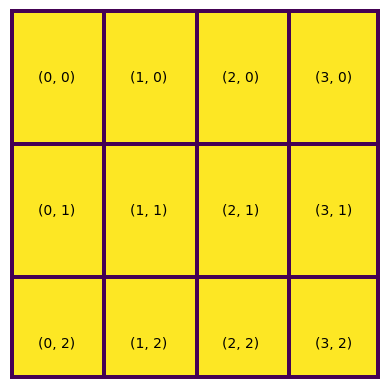

In [47]:
import numpy as np
import matplotlib.pyplot as plt

# Create a blank image with a grid of 100x100
grid_size = 100
image = np.ones((grid_size, grid_size), dtype=np.uint8) * 255

horizontal_spacing = np.random.randint(20,30)
vertical_spacing = np.random.randint(20,40)

image[:, 0] = 0
image[:, -1] = 0
image[0, :] = 0
image[-1, :] = 0
image[:,horizontal_spacing::horizontal_spacing] = 0
image[vertical_spacing::vertical_spacing, :] = 0

# Label each block accordingly
for i in range(0, grid_size, vertical_spacing):
    for j in range(0, grid_size, horizontal_spacing):
        x_label = j // horizontal_spacing
        y_label = i // vertical_spacing
        label = f"({x_label}, {y_label})"
        plt.text(j + horizontal_spacing//2, i + vertical_spacing//2, label, color='black',
                 ha='center', va='center')

# Display the resulting image
plt.imshow(image)
plt.axis('off')
plt.show()
